In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [4]:
run_qs = RunStats.objects.filter(psearch__id=89, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

,K,alpha,coherence,exclusivity,max_iter,rng_seed,run_id,top_chain_var
0,40,0.01,0.396576,0.730940,200,1,2354,0.050
1,40,0.01,0.445240,0.829526,200,1,2362,0.020
2,40,0.05,0.397664,0.738769,200,1,2366,0.050
3,40,0.05,0.467016,0.869076,200,1,2353,0.010
4,40,0.02,0.461092,0.861722,200,1,2363,0.010
5,35,0.01,0.419955,0.804016,200,1,2350,0.010
6,40,0.01,0.458939,0.868018,200,1,2351,0.010
7,45,0.01,0.480687,0.928956,200,1,2352,0.010
8,45,0.05,0.473385,0.912385,50,1,2156,0.010
9,45,0.01,0.464178,0.878157,50,1,2155,0.010


In [5]:
run_id = 2350

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 3933832.44997399}


,topic__id,topic__title,totalscore
0,184089,stop words,419821.116446
1,184090,procedural,367744.157874
2,184081,economic policy,216063.202495
3,184105,federal government,158838.262969
4,184102,policy statements,156957.446933
5,184106,budget,148827.974002
6,184086,European Coal and Steel Community,144982.504003
7,184098,international cooperation,142685.511866
8,184108,energy policy,134634.299691
9,184097,procedural 2,124332.949316


# party proportions aggregate over time

In [10]:
doc_scores_party = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False,
    document__parlperiod__n__isnull=False
).order_by().values('doctopic__score',
                    'doctopic__topic__title',
                    'speaker__party__name')

dft = pd.DataFrame.from_dict(doc_scores_party)
# to carry on other properties:
#dft.groupby(['doctopic__topic__id', 'speaker__party__name']).agg({'topic_score': 'sum', 'speaker__party__id': 'last'})
dft_scores = dft.groupby(['doctopic__topic__title', 'speaker__party__name']).sum().unstack()
dft_scores.columns = dft_scores.columns.droplevel()
dft_proportions = dft_scores / dft_scores.sum(0)

In [11]:
dft_proportions

speaker__party__name,afd,cducsu,fdp,gruene,linke,spd
doctopic__topic__title,,,,,,
European Coal and Steel Community,0.005708,0.033828,0.023592,0.007210,0.005835,0.039420
agricultural policy,0.001273,0.018039,0.017264,0.004259,0.001934,0.007080
budget,0.006349,0.053531,0.029642,0.011053,0.015038,0.032900
budget 2,0.002856,0.027551,0.022459,0.033243,0.011975,0.036955
climate protection,0.126476,0.015615,0.015453,0.092244,0.110214,0.018755
coal mining,0.000054,0.014773,0.011687,0.001095,0.001242,0.021580
coal policy & prices,0.001801,0.027128,0.021331,0.002929,0.003289,0.029904
debate government policy,0.193389,0.007980,0.011493,0.116177,0.098048,0.012256
economic policy,0.025262,0.061283,0.073815,0.017635,0.023189,0.051012


In [12]:
dft_proportions.max()

speaker__party__name
afd       0.193389
cducsu    0.098249
fdp       0.115593
gruene    0.121311
linke     0.126995
spd       0.115734
dtype: float64

In [13]:
dft_proportions.sum()

speaker__party__name
afd       1.0
cducsu    1.0
fdp       1.0
gruene    1.0
linke     1.0
spd       1.0
dtype: float64

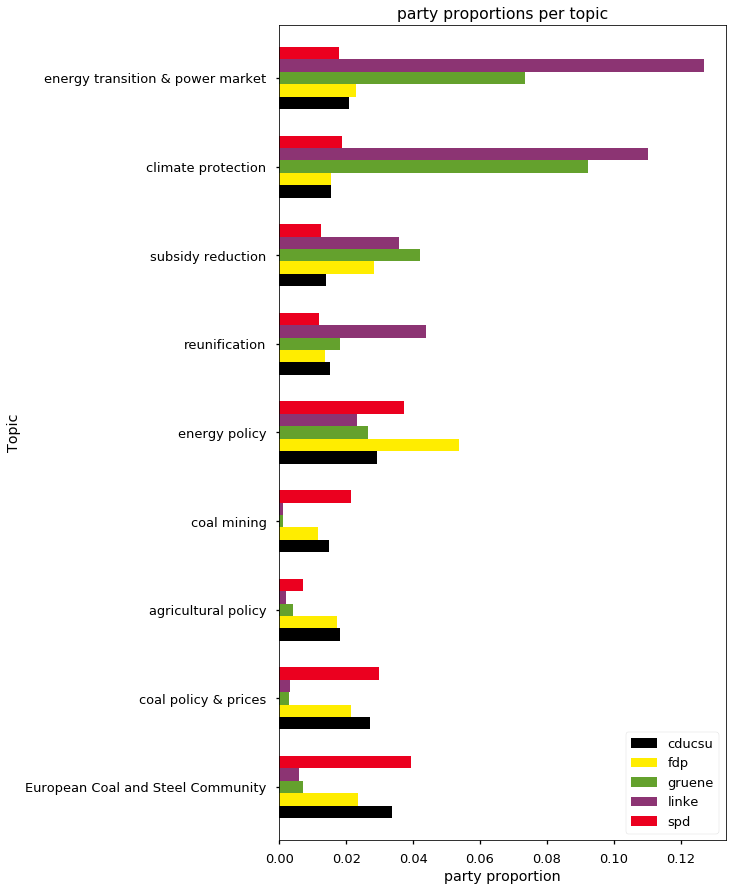

In [15]:
pct = False
stacked = False

# manual setting of colour, needs to be adjusted with new party or order change 
# with afd: party_colour = ["#0088FF", "#000000", "#FFED00", "#64A12D", "#8C3473", "#EB001F"]
party_colour = ["#000000", "#FFED00", "#64A12D", "#8C3473", "#EB001F"]

sns.set_palette(party_colour)
sns.set_context('talk')

#topics = list(reversed(["agriculture", "coal mining industry", "diplomacy & trade",
#                 "east germany", "energy technology", "federal coal policy",
#                 "hard coal mining", "international climate protection", "nuclear phase out 2",
#                 "pollution control", "research & development", "subsidies", "taxes"]))

topics = ["European Coal and Steel Community", "coal policy & prices", "agricultural policy",
                 "coal mining", "energy policy", "reunification",
                 "subsidy reduction", "climate protection", "energy transition & power market"]

dft_proportion = dft_proportions_new.loc[topics]

dft_proportion = dft_proportion.drop("afd", axis=1)

if pct:
    df_plot = dft_proportion.copy()
    for i in df_plot.index:
        df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
    xlabel = '% of party proportion'
    title_str = "Percentage of party proportions per topic"

else:
    xlabel = "party proportion"
    title_str = "party proportions per topic"
    df_plot = dft_proportion

ax = df_plot.plot.barh(stacked=stacked, # title=topic_names[0],
                 figsize=(8,15), width=0.7)

ax.set(xlabel=xlabel, ylabel='Topic', title=title_str)

if pct:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
else:
    plt.legend(title="")

filename = os.path.join(save_dir, "party_proportions_run_{}_selection".format(run_id))
plt.savefig(filename, dpi=300, bbox_inches="tight")

In [19]:
# the same for regions

# see also notebook topic_list_and_analysis_of_parties_and_regions

coal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony"])
non_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin", "Bremen", "Hamburg", "Hesse",
                    "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",
                    "Saarland", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"])


index_to_keyword = {0: 'coal', 1: 'ncoal'}
dfs = {}

for j, regions in enumerate([coal_regions, non_coal_regions]):
    print(list(regions))

    scores_list_qs = pm.Utterance.objects.filter(
            doctopic__topic__run_id=run_id,
            speaker__seat__seat_type=2,
            speaker__seat__list__region__in=regions
        ).distinct().order_by().values('doctopic__score', 'doctopic__topic__title')
    
    scores_list = pd.DataFrame.from_dict(scores_list_qs).groupby(['doctopic__topic__title']).sum().unstack()

    scores_direct_qs = pm.Utterance.objects.filter(
            doctopic__topic__run_id=run_id,
            speaker__seat__seat_type=1,
            speaker__seat__constituency__region__in=regions
        ).distinct().order_by().values('doctopic__score', 'doctopic__topic__title')
    
    scores_direct = pd.DataFrame.from_dict(scores_direct_qs).groupby(['doctopic__topic__title']).sum().unstack()

    df = scores_list.to_frame(name='list').join(scores_direct.to_frame(name='direct'))
    df.index = df.index.droplevel()
    df['sum'] = df.sum(1)
    dfs[index_to_keyword[j]] = df
    
region_scores = pd.concat(dfs.values(), axis=1, keys=dfs.keys())
region_proportions = region_scores / region_scores.sum()

rp_clean = region_proportions.loc[:, (slice(None),'sum')]
rp_clean.columns = rp_clean.columns.droplevel(1)
rp_clean

[<Region: Brandenburg>, <Region: North Rhine-Westphalia>, <Region: Saxony>]
[<Region: Baden-Württemberg>, <Region: Bavaria>, <Region: Berlin>, <Region: Bremen>, <Region: Hamburg>, <Region: Hesse>, <Region: Lower Saxony>, <Region: Mecklenburg-Vorpommern>, <Region: Rheinland-Pfalz>, <Region: Saarland>, <Region: Saxony-Anhalt>, <Region: Schleswig-Holstein>, <Region: Thuringia>]


,coal,ncoal
doctopic__topic__title,,
European Coal and Steel Community,0.035625,0.037213
agricultural policy,0.007216,0.015269
budget,0.027037,0.046178
budget 2,0.019520,0.033253
climate protection,0.029209,0.017565
coal mining,0.028979,0.011477
coal policy & prices,0.043809,0.022835
debate government policy,0.014933,0.018481
economic policy,0.052950,0.057506


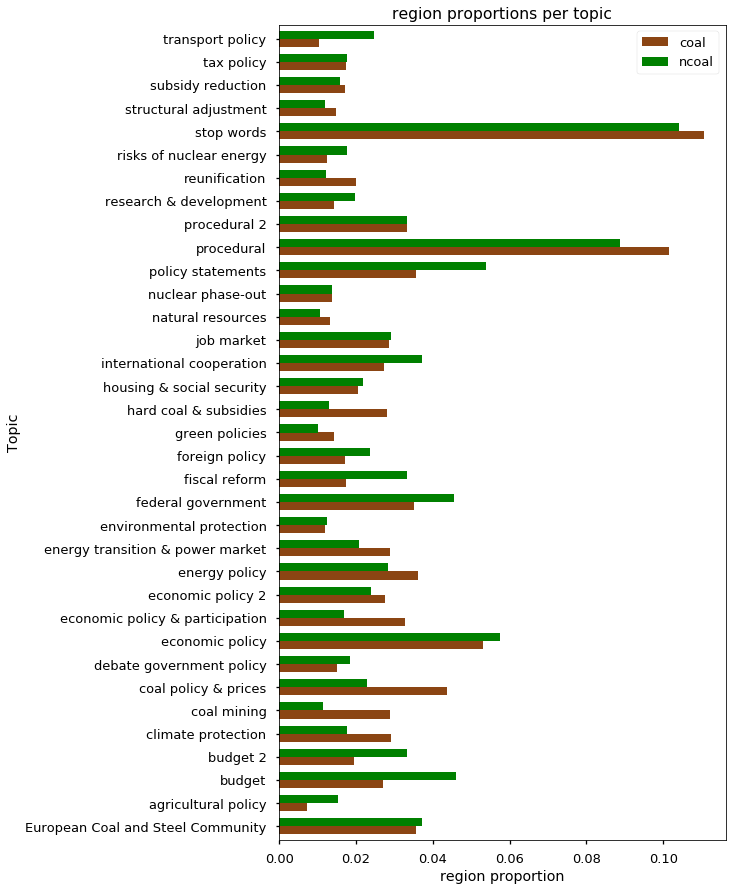

In [20]:
pct = False
stacked = False

# manual setting of colour, needs to be adjusted with new party or order change 
sns.set_palette(["saddlebrown", "green"])
sns.set_context('talk')

dft_proportion = rp_clean #.loc[topics]

if pct:
    df_plot = dft_proportion.copy()
    for i in df_plot.index:
        df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
    xlabel = '% of party proportion'
    title_str = "Percentage of party proportions per topic"

else:
    xlabel = "region proportion"
    title_str = "region proportions per topic"
    df_plot = dft_proportion

ax = df_plot.plot.barh(stacked=stacked, # title=topic_names[0],
                 figsize=(8,15), width=0.7)

ax.set(xlabel=xlabel, ylabel='Topic', title=title_str)

if pct:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
else:
    plt.legend(title="")

filename = os.path.join(save_dir, "region_proportions_run_{}_all".format(run_id))
plt.savefig(filename, dpi=300, bbox_inches="tight")

------------------------------------------------

# combine party and region proportions into one plot

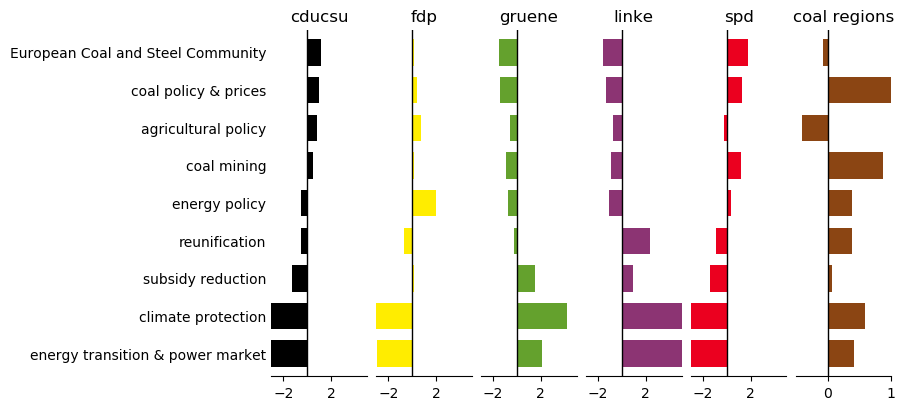

In [26]:
sns.reset_orig()

deviation = True
selection = True

parties = ["cducsu", "fdp", "gruene", "linke", "spd"]

if selection:
    selected_topics = list(reversed(topics))
else:
    selected_topics = rp_clean.index

dft_proportions_selected = 100 * dft_proportions.loc[selected_topics]
rp_selected = 100 * rp_clean.loc[selected_topics]

if deviation:
    dft_proportions_selected = dft_proportions_selected.sub(dft_proportions_selected[parties].mean(1), axis=0)
    rp_selected = rp_selected.sub(rp_selected.mean(1), axis=0)

if deviation:
    fig, ax = plt.subplots(1, len(parties) + 1, sharey=True, figsize=(8, len(selected_topics)/2))

else:
    fig, ax = plt.subplots(1, len(parties) + 2, sharex=True, sharey=True, figsize=(10, 5))


# plot party proportions
for i, party in enumerate(parties):
    dft_proportions_selected[party].plot.barh(ax=ax[i], color = party_colour[i], width=0.7)
    ax[i].set_ylabel('')
    ax[i].set_title(party)
    if deviation:
        ax[i].set_xlim([-3, 5])
        ax[i].set_xticks([-2, 2])
    
# plot region proportions

rp_selected['coal'].plot.barh(ax=ax[len(parties)], color = "saddlebrown", width=0.7)
ax[len(parties)].set_title('coal regions')
if deviation:
    ax[len(parties)].set_xlim([-0.5, 1])


if not deviation:
    rp_selected['ncoal'].plot.barh(ax=ax[len(parties) + 1], color = "green", width=0.7)
    ax[len(parties) + 1].set_title('non coal')

for a in ax:
    #a.yaxis.set_visible(False) # Hide only x axis
    a.tick_params(axis='y', length=0, which='both')
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines["left"].set_visible(False)
    a.axvline(x=0, ymin=0, ymax=1, color='k', linewidth=1)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

if selection:
    filename = os.path.join(save_dir, "party_and_region_proportions_deviation_run_{}_selection".format(run_id))
else:
    filename = os.path.join(save_dir, "party_and_region_proportions_deviation_run_{}_all".format(run_id))

plt.savefig(filename, dpi=300, bbox_inches="tight")

# compress folder to easily download it

In [27]:
%%bash
zip -r plots/topic_analysis_2350.zip plots/topic_analysis_2350/

updating: plots/topic_analysis_2350/ (stored 0%)
updating: plots/topic_analysis_2350/0_topic_list_run2350_labeled.csv (deflated 70%)
updating: plots/topic_analysis_2350/0_topic_list+peak_topwords_run2350.xlsx (deflated 5%)
updating: plots/topic_analysis_2350/.ipynb_checkpoints/ (stored 0%)
updating: plots/topic_analysis_2350/topic_evolution_run2350_aggregate.png (deflated 8%)
updating: plots/topic_analysis_2350/party_proportions_run_2350_selection.png (deflated 30%)
updating: plots/topic_analysis_2350/topic_evolution_shares_run2350_wo_procedural_barplot_simple.png (deflated 19%)
updating: plots/topic_analysis_2350/topic_evolution_scores_run2350_all.png (deflated 10%)
updating: plots/topic_analysis_2350/topic_evolution_shares_run2350_all.png (deflated 9%)
updating: plots/topic_analysis_2350/time+party/ (stored 0%)
updating: plots/topic_analysis_2350/time+party/party_scores_run_2350_topic_184087.png (deflated 24%)
updating: plots/topic_analysis_2350/time+party/party_proportions_run_2350_